In [2]:
import random

import numpy as np

from src.modules.training.datasets.main_dataset import MainDataset
from src.utils.setup import setup_data
# Import all important ML packages.
from src.utils.stratified_splitter import StratifiedSplitter
import pickle
import os
import random

## EEG

### Load in all the data and create a dataset

In [3]:
#Sample 10000 random indices from the training dataset and 2000 from the validation dataset.
random.seed(42)

#Pickle X_train, X_test, y_train, y_test  as 1 tuple if it does not exist yet.
n_samples = 5000

eeg_path = "../../data/raw/train_eegs"
meta_path = "../../data/raw/train.csv"
cache_path = "../../data/cache"

if not os.path.exists("train_test20k.pkl") or n_samples != 20000:
    #Start by setting up the data. Do not run if you already have the pickled data. 

    X, y = setup_data(eeg_path=eeg_path, metadata_path=meta_path, cache_path=cache_path, spectrogram_path=None)
    
    #Create a dataset
    splitter = StratifiedSplitter(n_splits=5)
    train_indices, test_indices = splitter.split(X.meta, y)[0]
    
    train_dataset = MainDataset("eeg")
    test_dataset = MainDataset("eeg")
    
    train_dataset.setup(X, y, train_indices, subsample_data=True)
    test_dataset.setup(X, y, test_indices, subsample_data=True)
    
    train_sample = random.sample(list(range(len(train_dataset.indices))), n_samples)
    val_sample = random.sample(list(range(len(test_dataset.indices))), len(test_dataset.indices))

    X_train = np.array([train_dataset.__getitem__(i)[0] for i in train_sample])
    y_train = np.array([train_dataset.__getitem__(i)[1] for i in train_sample])

    X_test = np.array([test_dataset.__getitem__(i)[0] for i in val_sample])
    y_test = np.array([test_dataset.__getitem__(i)[1] for i in val_sample])
    with open("train_test20k.pkl", "wb") as f:
        pickle.dump((X_train, X_test, y_train, y_test), f, protocol=pickle.HIGHEST_PROTOCOL)
else:
    with open("train_test20k.pkl", "rb") as f:
        X_train, X_test, y_train, y_test = pickle.load(f)


/home/hugo/Documents/Epoch/q3-harmful-brain-activity/src/utils/visualize_vote_distribution.py:34: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax[1].set_xticklabels(vote_columns, rotation=45, ha="right")
/home/hugo/Documents/Epoch/q3-harmful-brain-activity/src/utils/visualize_vote_distribution.py:37: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


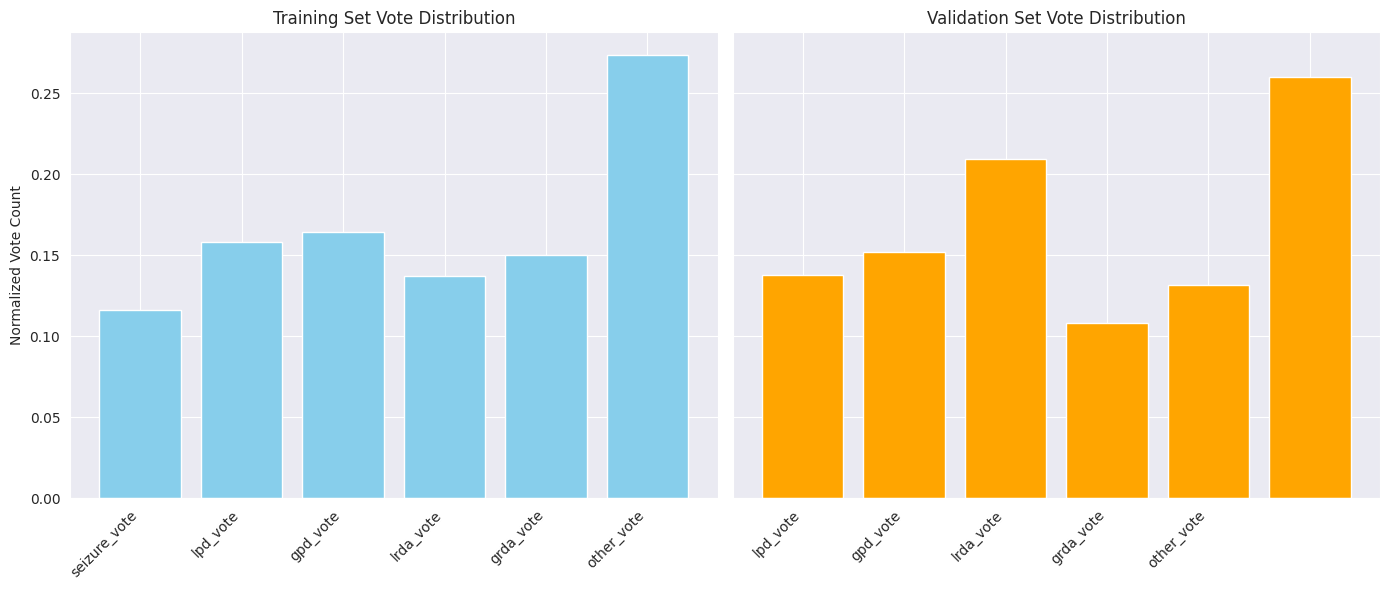

In [4]:
from src.utils.visualize_vote_distribution import visualize_vote_distribution
visualize_vote_distribution(y, train_indices, test_indices)

/home/hugo/Documents/Epoch/q3-harmful-brain-activity/src/utils/visualize_vote_distribution.py:34: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax[1].set_xticklabels(vote_columns, rotation=45, ha="right")
/home/hugo/Documents/Epoch/q3-harmful-brain-activity/src/utils/visualize_vote_distribution.py:37: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


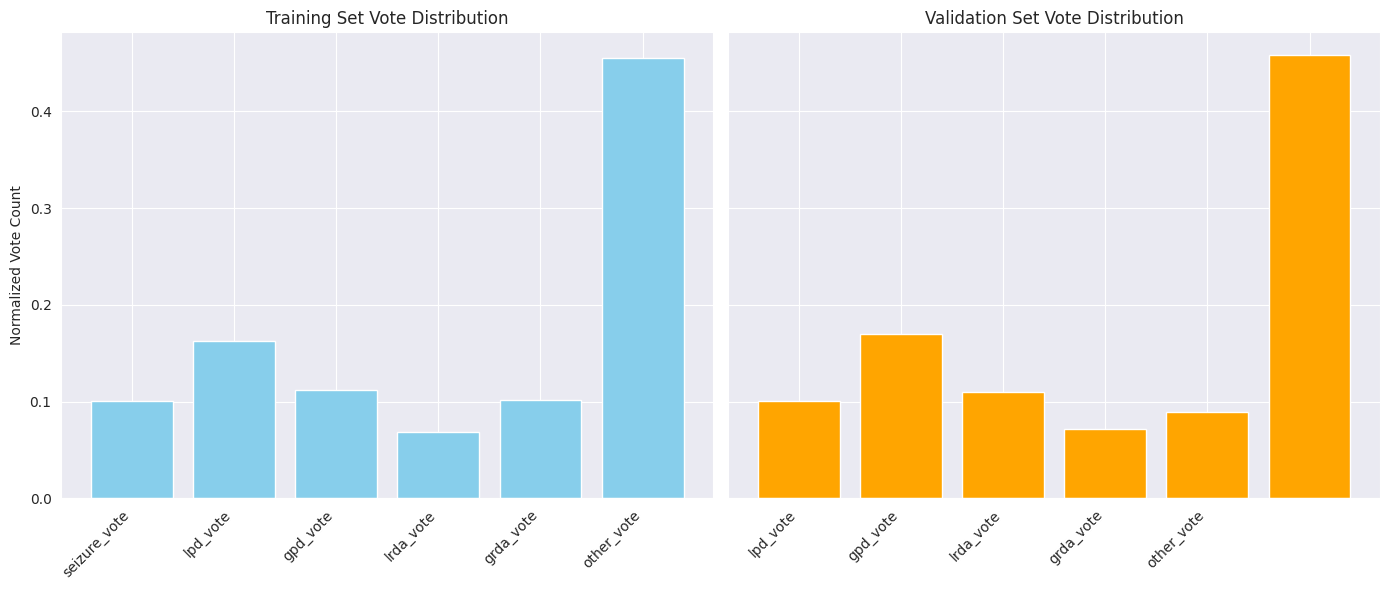

In [5]:
from src.utils.visualize_vote_distribution import visualize_vote_distribution
visualize_vote_distribution(y, train_dataset.indices, test_dataset.indices)

### Feature engineering

In [3]:
# Let's try statistical features such as rolling mean to start with on all channels 
# and then try to use the rolling mean on the channels that are most important.

In [6]:

import pandas as pd
import numpy as np
from numpy.lib.stride_tricks import sliding_window_view
from tqdm import tqdm


def channel_selection(data, channels):
    """
    Selects the specified channels from a 3D numpy array.
    
    Parameters:
        data (numpy.ndarray): The input data of shape (samples, sequence_length, channels).ff
        channels (list): The list of channels to select.
        
    Returns:
        numpy.ndarray: The data with the selected channels.
    """
    return data[:, :, channels]


def apply_downsampling(data, factor):
    """
    Downsamples a 3D numpy array by averaging over windows of the specified factor.
    
    Parameters:
        data (numpy.ndarray): The input data of shape (samples, sequence_length, channels).
        factor (int): The downsampling factor.
        
    Returns:
        numpy.ndarray: The downsampled data.
    """
    reshaped_data = data.reshape(data.shape[0], data.shape[1] // factor, factor, data.shape[2])

    # Compute the mean along the new axis that represents the blocks to be averaged
    downsampled_data = reshaped_data.mean(axis=2)

    return downsampled_data


def apply_rolling_operation(data, window_size, operation):
    """
    Applies a rolling operation (e.g., mean, std, min, max) to a 3D numpy array.
    
    Parameters:
        data (numpy.ndarray): The input data of shape (samples, sequence_length, channels).
        window_size (int): The size of the rolling window.
        operation (callable): The operation to apply within the rolling window.
        
    Returns:
        numpy.ndarray: The data with the rolling operation applied.
    """
    # Initialize the result array with NaNs to preserve original shape
    result = np.full(data.shape, np.nan)

    # Apply the rolling operation to each sample and channel
    for sample_idx in tqdm(range(data.shape[0])):
        for channel_idx in range(data.shape[2]):
            sequence = data[sample_idx, :, channel_idx]
            # Use sliding_window_view to create rolling windows
            windows = sliding_window_view(sequence, window_shape=window_size)
            # Apply the operation across the windows' axis (axis=-1) and assign to the result
            # Center the result of the operation in the middle of the window
            operation_result = operation(windows, axis=-1)
            start_index = window_size // 2
            end_index = start_index + operation_result.shape[0]
            result[sample_idx, start_index:end_index, channel_idx] = operation_result

            #Forward and backward fill the NaNs
            result[sample_idx, :, channel_idx] = pd.Series(result[sample_idx, :, channel_idx]).fillna(method="ffill").fillna(method="bfill")
    return result


def rolling_plot(X_train, X_test, window_size, operation):
    #Create a plot before and after.
    import matplotlib.pyplot as plt

    fig, ax = plt.subplots(2, 1, figsize=(20, 10))

    #Plot the original data for the first sample and channel
    ax[0].plot(X_train[0, :, 0])
    ax[0].set_title("Original data")

    # Assuming X_train and X_test are your datasets
    X_train = apply_rolling_operation(X_train, window_size, operation)
    X_test = apply_rolling_operation(X_test, window_size, operation)

    #Plot the transformed data for the first sample and channel
    ax[1].plot(X_train[0, :, 0])
    ax[1].set_title(f"Transformed data - rolling {str(operation)} with window size {window_size}")

    plt.show()

    return X_train, X_test

### Preprocess the data

In [7]:
#Remove the time dimension by flattening the data from (n, sequence_length, channels) to (n*sequence_length, channels).
def preprocess(X_train, X_test, y_train, y_test):
    sequence_length = X_train.shape[1]

    X_train = X_train.reshape(-1, X_train.shape[2])
    X_test = X_test.reshape(-1, X_test.shape[2])

    #Also process the labels from size (n, channels) to (n*sequence_length, channels).
    y_train = np.repeat(y_train, repeats=sequence_length, axis=0)
    y_test = np.repeat(y_test, repeats=sequence_length, axis=0)

    #Clip the data between -1024 and 1024.
    X_train = np.clip(X_train, -1024, 1024)
    X_test = np.clip(X_test, -1024, 1024)

    #Divide the data by 32
    X_train = X_train / 32
    X_test = X_test / 32

    #Set NaN to 0
    X_train = np.nan_to_num(X_train)
    X_test = np.nan_to_num(X_test)

    #Divide the labels by the sum of the labels to get a probability distribution.
    y_train = y_train / np.sum(y_train, axis=1).reshape(-1, 1)
    y_test = y_test / np.sum(y_test, axis=1).reshape(-1, 1)

    #Randomly shuffle train data
    np.random.seed(42)
    p = np.random.permutation(len(X_train))
    X_train = X_train[p]
    y_train = y_train[p]

    #One hot encode the labels
    y_train = np.argmax(y_train, axis=1)
    y_test = np.argmax(y_test, axis=1)

    return X_train, X_test, y_train, y_test

In [8]:
import xgboost as xgb
import lightgbm as lgb

def train(X_train, X_test, y_train, y_test):
    #Create a model
    model = xgb.XGBClassifier(num_class=6, max_depth=6, learning_rate=0.1, n_estimators=50,  verbosity=0, early_stopping_rounds=10)
    #Train a lightgbm model
    # model = lgb.LGBMClassifier(num_class=6, max_depth=10, n_estimators=100,  verbosity=0, early_stopping_rounds=10)
    # Use early stopping to stop the training if the validation score does not improve for 10 rounds.
    
    if isinstance(model, xgb.XGBClassifier):
        model.fit(X_train, y_train, eval_set=[(X_test, y_test)], verbose=False)
    elif isinstance(model, lgb.LGBMClassifier):
        model.fit(X_train, y_train, eval_set=[(X_test, y_test)])
    return model

In [9]:
#Calculate the accuracy and create a confusion matrix with seaborn
from sklearn.metrics import accuracy_score, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
from src.scoring.kldiv import KLDiv

def plot_confusion_matrix(y_test, y_pred, disable_plot=False):


    #Set the axis labels
    #Create the confusion matrix
    #Take the argmax of the probabilities to get the predicted class
    y_test_final = np.argmax(y_test, axis=1)
    y_pred_final = np.argmax(y_pred, axis=1)
    kldiv = KLDiv()
    score = kldiv(y_test, y_pred)
    accuracy = accuracy_score(y_test_final, y_pred_final)

    
    
    if not disable_plot:
        fig, ax = plt.subplots(figsize=(10, 10))
        print(f"KLDiv: {score}")
        print(f"Classification accuracy:  {accuracy}")
        sns.heatmap(confusion_matrix(y_test_final, y_pred_final), annot=True, fmt="d", ax=ax)
        ax.set_xlabel("Predicted")
        ax.set_ylabel("True")
    
        #Set the labels
        ax.set_xticklabels(["Seizure", "Lpd", "Gpd", "Lrda", "Grda", "Other"])
        ax.set_yticklabels(["Seizure", "Lpd", "Gpd", "Lrda", "Grda", "Other"])
        plt.show()
    return score, accuracy


In [10]:
def plot_feature_importances(model, feature_names, tsfresh=False):
    #Plot the feature importances with xgboost horizontally
    fig, ax = plt.subplots(1, 2, figsize=(35, 10))

    #Check if model is of type xgboost
    if isinstance(model, xgb.XGBClassifier):
        xgb.plot_importance(model, ax=ax[0], importance_type="gain")
    elif isinstance(model, lgb.LGBMClassifier):
        lgb.plot_importance(model, ax=ax[0], importance_type="gain")
        
    if not tsfresh:
        ax[0].set_yticklabels(feature_names)

    #Show plots/brain.png on the right
    ax[1].imshow(plt.imread("../../plots/brain.png"))

In [11]:
def pipeline(X_train, X_test, y_train, y_test):
    #Channel selection
    all_channels = ['Fp1', 'F3', 'C3', 'P3', 'F7', 'T3', 'T5', 'O1', 'Fz', 'Cz', 'Pz', 'Fp2', 'F4', 'C4', 'P4', 'F8', 'T4', 'T6', 'O2', 'EKG']
    channel_indices = range(len(all_channels))
    channel_dict = dict(zip(all_channels, channel_indices))
    selected_c = all_channels
    channels = [channel_dict[c] for c in selected_c]
    window_size = 175
    operation = np.std

    #Select the channels
    X_train = channel_selection(X_train, channels)
    X_test = channel_selection(X_test, channels)

    #Downsample the data
    X_train = apply_downsampling(X_train, 10)
    X_test = apply_downsampling(X_test, 10)

    #Apply the rolling operation
    X_train, X_test = rolling_plot(X_train, X_test, window_size, operation)

    #Now preprocess the data
    X_train, X_test, y_train, y_test = preprocess(X_train, X_test, y_train, y_test)

    #Train the model
    model = train(X_train, X_test, y_train, y_test)

    #Make predictions
    y_pred = model.predict(X_test)

    #Plot the confusion matrix
    plot_confusion_matrix(y_test, y_pred)

    #Plot the feature importances
    feature_names = np.array(X.eeg[list(X.eeg.keys())[0]].columns)[channels]
    plot_feature_importances(model, feature_names)

In [10]:
#Run the pipeline
#pipeline(X_train, X_test, y_train, y_test)

In [12]:
# Now lets use tsfresh for feature engineering

def preprocess_to_df(X, all_channels):
    
    #Clip the data between -1024 and 1024.
    X = np.clip(X, -1024, 1024)
    #Divide the data by 32
    X = X / 32
    #Set NaN to 0
    X = np.nan_to_num(X)
    id = np.repeat(range(X.shape[0]), X.shape[1])
    X = X.reshape(-1, X.shape[2])
    df = pd.DataFrame(X, columns=all_channels)
    del X
    df["id"] = id
    return df



def apply_rolling(X: pd.DataFrame, window_sizes: list, operations: list):
    """
    Applies a rolling operation (e.g., mean, std, min, max) to a 3D numpy array.
    
    Parameters:
        data (numpy.ndarray): The input data of shape (samples, sequence_length, channels).
        window_size (int): The size of the rolling window.
        operation (callable): The operation to apply within the rolling window.
        
    Returns:
        numpy.ndarray: The data with the rolling operation applied.
    """
    # Initialize the result array with NaNs to preserve original shape
    result = pd.DataFrame()
    # Apply the rolling operation to each sample and channel (exclude Id)
    for channel, window_size, operation in zip(X.columns[:-1], window_sizes, operations): 
        #Convert operation from string to callable
        result[channel] = X[channel].groupby(X["id"]).rolling(window=window_size).agg(operation).ffill().bfill().astype(np.float32)
        #Rename the current column
        result.rename(columns={channel: f"{channel}_{operation}_{window_size}"}, inplace=True)
        
    return result


def preprocess_tf(y):
    #One hot encode the labels
    y = np.argmax(y, axis=1)
    #Repeat y based on 
    return y


In [13]:
from tsfresh import select_features


def pipeline_single(X_train, X_test, y_train, y_test):
    all_channels = ['Fp1', 'F3', 'C3', 'P3', 'F7', 'T3', 'T5', 'O1', 'Fz', 'Cz', 'Pz', 'Fp2', 'F4', 'C4', 'P4', 'F8', 'T4', 'T6', 'O2', 'EKG']
    unary_ops = ['abs']
    stats = ['mean', 'std', 'min', 'max', 'median', 'skew','kurt']
    window_sizes = [6, 12, 36, 50, 90, 180, 360, 500, 1000]
    downsample = 10
    channel_indices = range(len(all_channels))
    channel_dict = dict(zip(all_channels, channel_indices))
    
    scores = dict()
    accuracies = dict()
    def objective(trial):
       
        #Select a random number of  channels, for now lets do one.
        # num_channels = random.randint(1, 20)
        num_channels = 1
        
        #Select the channels using optuna
        selected_c = trial.suggest_categorical("channels", all_channels)
        channels = [channel_dict[selected_c]]
        
        # Select window size
        window_size = trial.suggest_categorical("window_size", window_sizes)
        
        # Select operation
        operation = trial.suggest_categorical("operation", stats)
        
        #Select the channels
        X_train_curr = channel_selection(X_train, channels)
        X_test_curr = channel_selection(X_test, channels)
        
        #Trial boolean for abs
        unary = trial.suggest_categorical("abs", [True, False])
        if unary:
            X_train_curr = np.abs(X_train_curr)
            X_test_curr = np.abs(X_test_curr)
        
        #Repeat y based on the sequence length
        y_train_curr = np.repeat(y_train, repeats=X_train.shape[1] / downsample, axis=0)
        y_test_curr = np.repeat(y_test, repeats=X_test.shape[1] / downsample, axis=0)
    
        #Downsample the data
        X_train_curr = apply_downsampling(X_train_curr, downsample)
        X_test_curr = apply_downsampling(X_test_curr, downsample)
    

        #Apply the rolling operation
        X_train_curr = preprocess_to_df(X_train_curr, [selected_c])
        X_test_curr = preprocess_to_df(X_test_curr, [selected_c])
        
        X_train_curr = apply_rolling(X_train_curr, [window_size], [operation])
        X_test_curr = apply_rolling(X_test_curr, [window_size], [operation])
        
        #Now preprocess the data
        y_train_curr_final = preprocess_tf(y_train_curr)
        y_test_curr_final = preprocess_tf(y_test_curr)
        
        #Train the model
        model = train(X_train_curr, X_test_curr, y_train_curr_final, y_test_curr_final)
    
        #Make predictions with probabilities
        y_pred = model.predict_proba(X_test_curr)
    
        #Plot the confusion matrix
        score, accuracy = plot_confusion_matrix(y_test_curr, y_pred, disable_plot=True)
        
        #Save the scores
        scores[f"{selected_c[0]}-{downsample}-{window_size}-{operation}"] = score
        accuracies[f"{downsample}-{window_size}-{operation}"] = accuracy
        
        return score
    return objective

#Train a config with these keys
def train_config(X_train, X_test, y_train, y_test, config):
    all_channels = ['Fp1', 'F3', 'C3', 'P3', 'F7', 'T3', 'T5', 'O1', 'Fz', 'Cz', 'Pz', 'Fp2', 'F4', 'C4', 'P4', 'F8', 'T4', 'T6', 'O2', 'EKG']
    channel_indices = range(len(all_channels))
    channel_dict = dict(zip(all_channels, channel_indices))
    
    curr_channels = [channel_dict[c.split("-")[1]] for c in config[0]]
    
    #Select the channels
    X_train_curr = channel_selection(X_train, curr_channels)
    X_test_curr = channel_selection(X_test, curr_channels)
    
    #Repeat y based on the sequence length
    y_train_curr = np.repeat(y_train, repeats=X_train.shape[1] / config[1][0], axis=0)
    y_test_curr = np.repeat(y_test, repeats=X_test.shape[1] / config[1][0], axis=0)
    
    #Downsample the data
    X_train_curr = apply_downsampling(X_train_curr, config[1][0])
    X_test_curr = apply_downsampling(X_test_curr, config[1][0])
    
    #Apply the rolling operation
    X_train_curr = preprocess_to_df(X_train_curr, config[0])
    X_test_curr = preprocess_to_df(X_test_curr, config[0])
    X_train_curr = apply_rolling(X_train_curr, config[2], config[3])
    X_test_curr = apply_rolling(X_test_curr, config[2], config[3])
    
    #Now preprocess the data
    y_train_curr_final = preprocess_tf(y_train_curr)
    y_test_curr_final = preprocess_tf(y_test_curr)
    
    #Train the model
    model = train(X_train_curr, X_test_curr, y_train_curr_final, y_test_curr_final)
    
    #Make predictions with probabilities
    y_pred = model.predict_proba(X_test_curr)
    
    #Plot the confusion matrix
    score, accuracy = plot_confusion_matrix(y_test_curr, y_pred, disable_plot=False)
    
    #Plot the feature importances
    feature_names = [c[1:] for c in X_train_curr.columns]
    plot_feature_importances(model, feature_names, tsfresh=True)
    return score, accuracy

### OPTUNA - Double channel search



In [14]:
def pipeline_double(X_train, X_test, y_train, y_test):
    all_channels = ['Fp1', 'F3', 'C3', 'P3', 'F7', 'T3', 'T5', 'O1', 'Fz', 'Cz', 'Pz', 'Fp2', 'F4', 'C4', 'P4', 'F8', 'T4', 'T6', 'O2', 'EKG']
    operations = ["/", "+", "-", "*"]
    stats = ['mean', 'std', 'min', 'max', 'median', 'skew','kurt']
    window_sizes = [5, 12, 25,40, 50, 100, 200]
    downsample = 10
    channel_indices = range(len(all_channels))
    channel_dict = dict(zip(all_channels, channel_indices))
    
    #Create plots folder if it does not exist
    if not os.path.exists("plots"):
        os.makedirs("plots")
    
    cache = {}
    
    def objective(trial):
        #Get the study name
        study_name = trial.study.study_name
        #Create folder if it does not exist
        if not os.path.exists(f"plots/{study_name}"):
            os.makedirs(f"plots/{study_name}")
        
        fig, ax = plt.subplots(2, 1, figsize=(20, 10))
        
        #Suggest all for the trial
        c1 = trial.suggest_categorical("c1", all_channels)
        c2 = trial.suggest_categorical("c2", all_channels)
        op = trial.suggest_categorical("operation", operations)
        # Select window size
        window_size = trial.suggest_categorical("window_size", window_sizes)
        # Select operation
        operation = trial.suggest_categorical("rolling", stats)
        
        all_params = str([c1, c2, op, window_size, operation])
        if all_params in cache:
            return cache[all_params]
    
        curr_c1 = [channel_dict[c1]]
        X_train_c1 = channel_selection(X_train, curr_c1)
        
        ax[0].plot(X_train_c1[0, :, 0], label=f"{c1}")
        
        #Do the same for the second channel

        curr_c2 = [channel_dict[c2]]
        X_train_c2 = channel_selection(X_train, curr_c2)
        
        ax[0].plot(X_train_c2[0, :, 0], label=f"{c2}")
        #Do the same for test
        X_test_c1 = channel_selection(X_test, curr_c1)
        X_test_c2 = channel_selection(X_test, curr_c2)
        
        #Apply the operation
        X_train_curr = apply_op(X_train_c1, X_train_c2, op)
        X_test_curr = apply_op(X_test_c1, X_test_c2, op)
 
        ax[0].plot(X_train_curr[0, :, 0], label=f"{c1}{op}{c2}")
        ax[0].legend()

        #Repeat y based on the sequence length
        repeats = X_train.shape[1] // downsample
        y_train_curr = np.repeat(y_train, repeats=repeats, axis=0)
        y_test_curr = np.repeat(y_test, repeats=repeats, axis=0)
    
        #Downsample the data
        X_train_curr = apply_downsampling(X_train_curr, downsample)
        X_test_curr = apply_downsampling(X_test_curr, downsample)
    
        #Apply the rolling operation
        X_train_curr = preprocess_to_df(X_train_curr, [f"{c1}{op}{c2}"])
        X_test_curr = preprocess_to_df(X_test_curr, [f"{c1}{op}{c2}"])
        
        X_train_curr = apply_rolling(X_train_curr, [window_size, window_size], [operation, operation])
        X_test_curr = apply_rolling(X_test_curr, [window_size, window_size], [operation, operation])
        
        #Now preprocess the data
        y_train_curr_final = preprocess_tf(y_train_curr)
        y_test_curr_final = preprocess_tf(y_test_curr)
        
        #Train the model
        model = train(X_train_curr, X_test_curr, y_train_curr_final, y_test_curr_final)
    
        #Make predictions with probabilities
        y_pred = model.predict_proba(X_test_curr)
    
        #Plot the confusion matrix
        score, accuracy = plot_confusion_matrix(y_test_curr, y_pred, disable_plot=True)
        
        #Add to cache
        cache[all_params] = score
        
        #Plot the transformed data for the first sample and channel
        ax[1].plot(X_train_curr.iloc[:repeats].to_numpy().flatten(), label=f"{c1}{op}{c2} with window size {window_size} and operation {operation}")
        ax[1].legend()
        
        ax[0].set_title(f"Plot with score {score} and accuracy {accuracy}.")
        #Save plot to file based on the trial count + score#
        plt.savefig(f"plots/{study_name}/{trial.number}_{score}.png")
        plt.close()
        
        return score
    return objective

def apply_op(X_c1, X_c2, operation):
    #Apply the operation 
    if operation == "/":
        return X_c1 / X_c2
    elif operation == "+":
        return X_c1 + X_c2
    elif operation == "-":
        return X_c1 - X_c2
    elif operation == "*":
        return X_c1 * X_c2
    
def apply_op_channels(X_c1, X_c2, operation):
    #Apply the operation for each channel
    #Create an empty array
    result = np.zeros(X_c1.shape)
    for i, op in enumerate(operation):
        if op == "/":
            result[:, :, i] = X_c1[:, :, i] / X_c2[:, :, i]
        elif op == "+":
            result[:, :, i] = X_c1[:, :, i] + X_c2[:, :, i]
        elif op == "-":
            result[:, :, i] = X_c1[:, :, i] - X_c2[:, :, i]
        elif op == "*":
            result[:, :, i] = X_c1[:, :, i] * X_c2[:, :, i]
    return result
        
       
#Train a config with these keys
def train_config_double(X_train, X_test, y_train, y_test, config):
    all_channels = ['Fp1', 'F3', 'C3', 'P3', 'F7', 'T3', 'T5', 'O1', 'Fz', 'Cz', 'Pz', 'Fp2', 'F4', 'C4', 'P4', 'F8', 'T4', 'T6', 'O2', 'EKG']
    channel_indices = range(len(all_channels))
    channel_dict = dict(zip(all_channels, channel_indices))
    
    curr_c1s = [channel_dict[c.split("-")[1]] for c in config[0]]
    curr_c2s = [channel_dict[c.split("-")[1]] for c in config[1]]
    
    #Select the channels
    X_train1_curr = channel_selection(X_train, curr_c1s)
    X_train2_curr = channel_selection(X_train, curr_c2s)
    
    X_test1_curr = channel_selection(X_test, curr_c1s)
    X_test2_curr = channel_selection(X_test, curr_c2s)
    
    #Apply the operation
    X_train_curr = apply_op_channels(X_train1_curr, X_train2_curr, config[3])
    X_test_curr = apply_op_channels(X_test1_curr, X_test2_curr, config[3])
    
    del X_train1_curr, X_train2_curr, X_test1_curr, X_test2_curr
    #Repeat y based on the sequence length
    y_train_curr = np.repeat(y_train, repeats=X_train.shape[1] / config[2][0], axis=0)
    y_test_curr = np.repeat(y_test, repeats=X_test.shape[1] / config[2][0], axis=0)
    
    #Downsample the data
    X_train_curr = apply_downsampling(X_train_curr, config[2][0])
    X_test_curr = apply_downsampling(X_test_curr, config[2][0])
    
    #Apply the rolling operation
    X_train_curr = preprocess_to_df(X_train_curr, [f"{c1}{op}{c2}" for c1, c2, op in zip(config[0], config[1], config[3])])
    X_test_curr = preprocess_to_df(X_test_curr, [f"{c1}{op}{c2}" for c1, c2, op in zip(config[0], config[1], config[3])])
    
    X_train_curr = apply_rolling(X_train_curr, config[4], config[5])
    X_test_curr = apply_rolling(X_test_curr, config[4], config[5])
    
    #Now preprocess the data
    y_train_curr_final = preprocess_tf(y_train_curr)
    y_test_curr_final = preprocess_tf(y_test_curr)
    
    #Train the model
    model = train(X_train_curr, X_test_curr, y_train_curr_final, y_test_curr_final)
    
    #Make predictions with probabilities
    y_pred = model.predict_proba(X_test_curr)
    
    #Plot the confusion matrix
    score, accuracy = plot_confusion_matrix(y_test_curr, y_pred, disable_plot=False)
    
    #Plot the feature importances
    feature_names = [c[1:] for c in X_train_curr.columns]
    plot_feature_importances(model, feature_names, tsfresh=True)
    return score, accuracy

### OPTUNA - Single channel search

Uncomment if you want to run.

In [16]:
import optuna

In [14]:

optuna_storage = "sqlite:///optuna.db"
study = optuna.create_study(study_name="single_channel", storage=optuna_storage, load_if_exists=True, direction="minimize")

[I 2024-03-19 15:48:04,901] Using an existing study with name 'single_channel' instead of creating a new one.


In [15]:
#study.optimize(pipeline_single(X_train, X_test, y_train, y_test), n_trials=500)

In [16]:
#Get the best runs from the study
# sorted_trials = sorted(study.trials, key=lambda t: t.value if t.value is not None else float('inf'))
# 
# # Filter out duplicates based on parameter values
# seen_params = set()
# unique_trials = []
# for trial in sorted_trials:
#     # Create a unique representation of the trial's parameters (e.g., as a tuple of sorted items)
#     params_repr = tuple(sorted(trial.params.items()))
#     if params_repr not in seen_params:
#         unique_trials.append(trial)
#         seen_params.add(params_repr)
#     
#     # Stop once we have collected 10 unique trials
#     if len(unique_trials) == 50:
#         break
# 
# top_10 = [trial.params for trial in unique_trials]
# 
# config_channels = [str(i) + "-" + config["channels"]for i,config in zip(range(len(top_10)), top_10)]
# config_downsample = [10] * 15
# config_window = [config["window_size"] for config in top_10]
# config_operation = [config["operation"] for config in top_10]
# config = [config_channels, config_downsample, config_window, config_operation]
# train_config(X_train, X_test, y_train, y_test, config)

### OPTUNA Double channel search run

In [17]:
optuna_storage = "sqlite:///optuna.db"
study = optuna.create_study(study_name="double_channel_new_splitter", storage=optuna_storage, load_if_exists=True, direction="minimize")
import warnings
warnings.filterwarnings("ignore")

[I 2024-03-19 17:00:11,467] Using an existing study with name 'double_channel_new_splitter' instead of creating a new one.


In [ ]:
study.optimize(pipeline_double(X_train, X_test, y_train, y_test), n_trials=1000)

KLDiv: 1.205608792959812
Classification accuracy:  0.4372877415458937


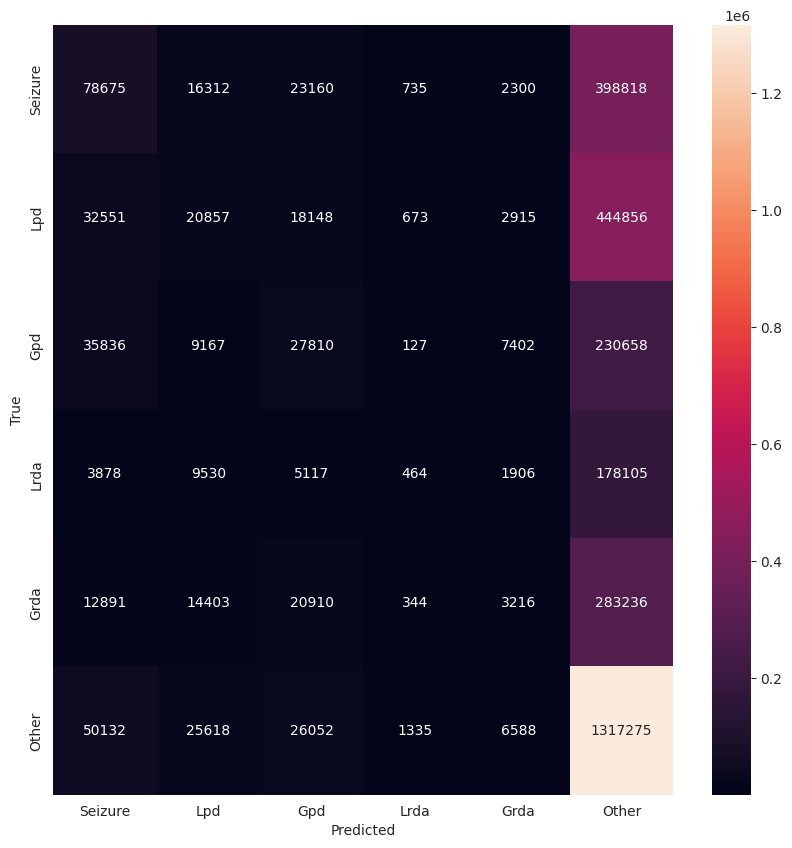

(tensor(1.2056, dtype=torch.float64), 0.4372877415458937)

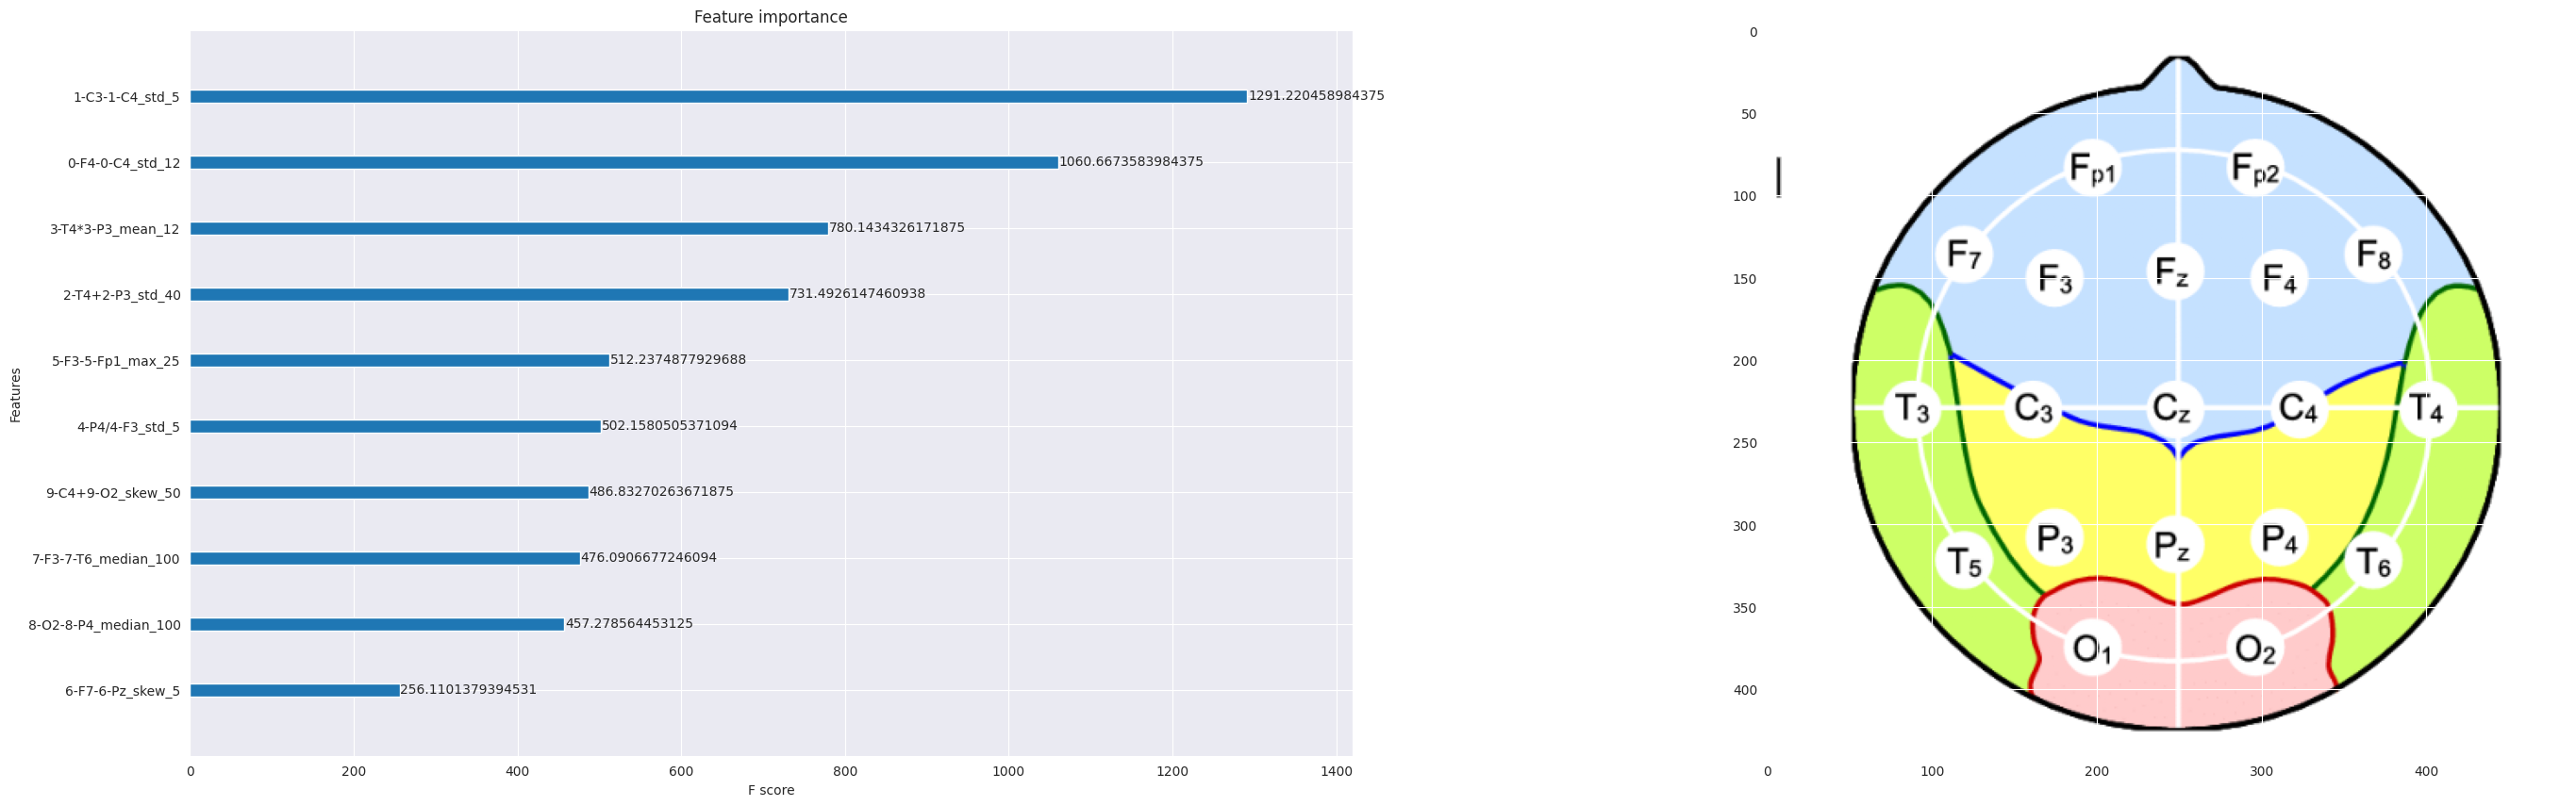

In [24]:
#Set the number of runs
n = 10

#Get the best runs from the study
sorted_trials = sorted(study.trials, key=lambda t: t.value if t.value is not None else float('inf'))

# Filter out duplicates based on parameter values
seen_params = set()
unique_trials = []
for trial in sorted_trials:
    # Create a unique representation of the trial's parameters (e.g., as a tuple of sorted items)
    params_repr = tuple(sorted(trial.params.items()))
    if params_repr not in seen_params:
        unique_trials.append(trial)
        seen_params.add(params_repr)
    
    # Stop once we have collected 10 unique trials
    if len(unique_trials) == n:
        break

top_n = [trial.params for trial in unique_trials]

config_c1s = [str(i) + "-" + config["c1"]for i,config in zip(range(len(top_n)), top_n)]
config_c2s = [str(i) + "-" + config["c2"]for i,config in zip(range(len(top_n)), top_n)]
config_downsample = [10] * n
config_operation = [config["operation"] for config in top_n]
config_window = [config["window_size"] for config in top_n]
config_rolling = [config["rolling"] for config in top_n]
config = [config_c1s, config_c2s, config_downsample, config_operation, config_window, config_rolling]
train_config_double(X_train, X_test, y_train, y_test, config)

### Run with the best parameters